In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
file = open(r'C:\Users\이예일\Downloads\WISDM_ar_v1.1_raw.txt', encoding='utf-8', errors='ignore')
lines = file.readlines()

processedList = []
for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
           continue
        temp = [
            int(line[0]),    # user_id
            line[1],         # activity (string)
            line[2],         # timestamp (string)
            float(line[3]),  # x
            float(line[4]),  # y
            float(last)      # z
        ]
        processedList.append(temp)
    except Exception as e:
        print('Error at line number:', i, '->', e)


Error at line number: 281873 -> list index out of range
Error at line number: 281874 -> list index out of range
Error at line number: 281875 -> list index out of range
Error at line number: 537501 -> list index out of range
Error at line number: 832901 -> list index out of range
Error at line number: 1098209 -> list index out of range


In [4]:
cols = ['user_id','activity','timestamp','x','y','z']
df = pd.DataFrame(processedList, columns=cols)

In [5]:
print("결측치 개수:\n", df.isna().sum())

결측치 개수:
 user_id      0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64


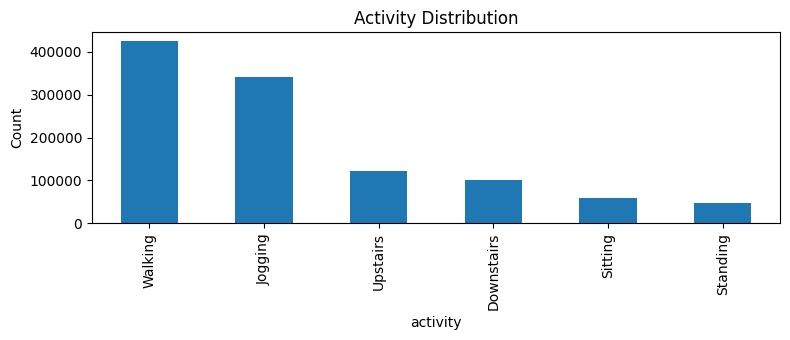

In [6]:
plt.figure(figsize=(8,3.5))
df['activity'].value_counts().plot(kind='bar')
plt.title("Activity Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


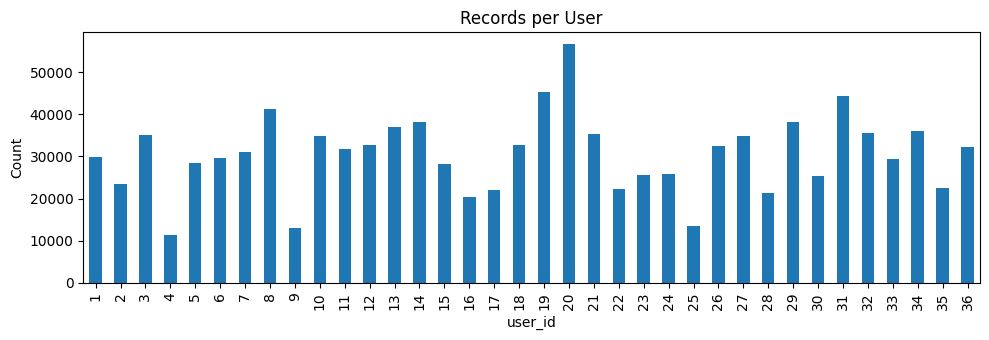

In [7]:

plt.figure(figsize=(10,3.5))
df['user_id'].value_counts().sort_index().plot(kind='bar')
plt.title("Records per User")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [8]:
trainval_df = df[df['user_id'] < 30].copy()
test_df = df[df['user_id'] >= 30].copy()

trainval_users = sorted(trainval_df['user_id'].unique())
permuted_users = np.random.permutation(trainval_users)
val_ratio = 0.2
val_count = max(1, int(len(permuted_users) * val_ratio))
if val_count >= len(permuted_users):
    val_count = max(1, len(permuted_users) - 1)
val_users = sorted(permuted_users[:val_count].tolist())
train_users = sorted(permuted_users[val_count:].tolist())

train_df = trainval_df[trainval_df['user_id'].isin(train_users)].copy()
val_df = trainval_df[trainval_df['user_id'].isin(val_users)].copy()

print("Train users:", train_users)
print("Val   users:", val_users)
print("Test  users:", sorted(test_df['user_id'].unique()))


Train users: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29]
Val   users: [9, 13, 17, 23, 28]
Test  users: [np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [9]:
scaler = StandardScaler()
train_df[['x','y','z']] = scaler.fit_transform(train_df[['x','y','z']])
val_df[['x','y','z']] = scaler.transform(val_df[['x','y','z']])
test_df[['x','y','z']] = scaler.transform(test_df[['x','y','z']])


In [10]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['activity'])
val_df['label'] = le.transform(val_df['activity'])
test_df['label'] = le.transform(test_df['activity'])


In [11]:
class_names = le.classes_.tolist()
n_classes = len(class_names)
print(class_names)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [12]:
FRAME_SIZE = 200
HOP_SIZE   = 40

In [13]:
def get_frames(df_in, frame_size, hop_size):
    """
    df_in: 반드시 ['x','y','z','label'] 포함
    반환: X -> (num_segments, frame_size, 3), y -> (num_segments,) (정수라벨)
    """
    N_FEATURES = 3
    frames, labels = [], []
    # +1로 마지막 구간 손실 방지, 최신 SciPy 대응 keepdims=False
    for i in range(0, len(df_in) - frame_size + 1, hop_size):
        x = df_in['x'].values[i: i + frame_size]
        y = df_in['y'].values[i: i + frame_size]
        z = df_in['z'].values[i: i + frame_size]

        mode_label = stats.mode(df_in['label'].iloc[i: i + frame_size], keepdims=False)[0]
        frames.append(np.vstack([x,y,z]).T)  # (frame, 3)
        labels.append(mode_label)

    X = np.asarray(frames, dtype=np.float32).reshape(-1, frame_size, N_FEATURES)
    y = np.asarray(labels, dtype=np.int64)
    return X, y

In [14]:
def build_xy_by_user(df_split, frame_size=FRAME_SIZE, hop_size=HOP_SIZE):
    X_list, y_list = [], []
    for _, g in df_split.groupby('user_id', sort=False):
        if len(g) >= frame_size:
            Xg, yg = get_frames(g, frame_size, hop_size)
            if len(yg) > 0:
                X_list.append(Xg); y_list.append(yg)
    if not X_list:
        return np.empty((0, frame_size, 3), dtype=np.float32), np.empty((0,), dtype=np.int64)
    X = np.vstack(X_list).astype('float32')
    y = np.concatenate(y_list)
    return X, y

In [15]:
X_train, y_train_int = build_xy_by_user(train_df, FRAME_SIZE, HOP_SIZE)
X_val,   y_val_int   = build_xy_by_user(val_df,   FRAME_SIZE, HOP_SIZE)
X_test,  y_test_int  = build_xy_by_user(test_df,  FRAME_SIZE, HOP_SIZE)


In [16]:
print("X_train:", X_train.shape, "| y_train_int:", y_train_int.shape)
print("X_val  :", X_val.shape,   "| y_val_int  :", y_val_int.shape)
print("X_test :", X_test.shape,  "| y_test_int :", y_test_int.shape)


X_train: (18741, 200, 3) | y_train_int: (18741,)
X_val  : (2954, 200, 3) | y_val_int  : (2954,)
X_test : (5598, 200, 3) | y_test_int : (5598,)


In [17]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train = ohe.fit_transform(y_train_int.reshape(-1,1))
y_val = ohe.transform(y_val_int.reshape(-1,1))
y_test = ohe.transform(y_test_int.reshape(-1,1))
# 안전 확인: ohe.categories_[0]는 [0..n_classes-1] 일 것
assert len(ohe.categories_[0]) == n_classes


In [18]:
print("y_train(one-hot):", y_train.shape)
print("y_val  (one-hot):", y_val.shape)
print("y_test (one-hot):", y_test.shape)


y_train(one-hot): (18741, 6)
y_val  (one-hot): (2954, 6)
y_test (one-hot): (5598, 6)


In [19]:
n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
n_outputs   = y_train.shape[1]

inputs = keras.Input(shape=(n_timesteps, n_features))
x = layers.Conv1D(64, 5, strides=2, padding='same', activation='relu')(inputs)
x = layers.MaxPooling1D(2, strides=2)(x)

x = layers.Conv1D(96, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(2, strides=2)(x)

x = layers.Conv1D(96, 3, strides=1, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(n_outputs, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 96)         │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 96)         │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,262 (188.52 KB)

 Trainable params: 48,070 (187.77 KB)

 Non-trainable params: 192 (768.00 B)

In [20]:
EPOCHS = 10
BATCH  = 64
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1
)


Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8062 - loss: 0.5645 - val_accuracy: 0.7739 - val_loss: 0.6790
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9621 - loss: 0.1160 - val_accuracy: 0.7837 - val_loss: 0.8880
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9761 - loss: 0.0717 - val_accuracy: 0.8064 - val_loss: 0.9828
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9821 - loss: 0.0526 - val_accuracy: 0.7830 - val_loss: 1.3740
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9865 - loss: 0.0416 - val_accuracy: 0.7840 - val_loss: 1.3623
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9863 - loss: 0.0365 - val_accuracy: 0.7979 - val_loss: 1.2834
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9897 - loss: 0.0308 - val_accuracy: 0.7752 - val_loss: 1.7958
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9886 - loss: 0.0338 - val_accuracy: 0.

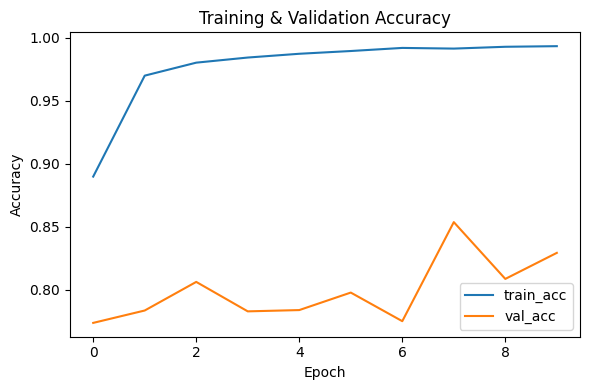

In [21]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

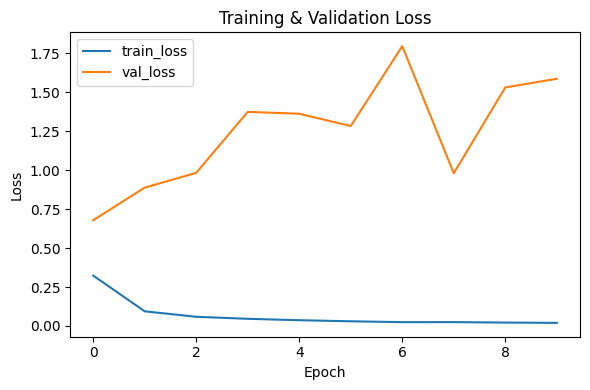

In [22]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
y_pred_prob = model.predict(X_test, batch_size=BATCH, verbose=0)
y_pred_int  = np.argmax(y_pred_prob, axis=1)


In [24]:
test_accuracy = accuracy_score(y_test_int, y_pred_int)
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    y_test_int, y_pred_int, average='weighted', zero_division=0
)

print("Test Metrics:")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {precision_w:.4f}")
print(f"Recall   : {recall_w:.4f}")
print(f"F1-score : {f1_w:.4f}")

print("Classification Report:")
print(classification_report(y_test_int, y_pred_int, target_names=class_names, digits=4))


Test Metrics:
Accuracy : 0.8496
Precision: 0.8589
Recall   : 0.8496
F1-score : 0.8507
Classification Report:
              precision    recall  f1-score   support

  Downstairs     0.6781    0.7320    0.7040       541
     Jogging     0.8044    0.9250    0.8605      1667
     Sitting     0.9429    0.8966    0.9192       387
    Standing     0.8754    0.9321    0.9028       324
    Upstairs     0.7942    0.8165    0.8052       605
     Walking     0.9506    0.8076    0.8733      2074

    accuracy                         0.8496      5598
   macro avg     0.8409    0.8516    0.8442      5598
weighted avg     0.8589    0.8496    0.8507      5598



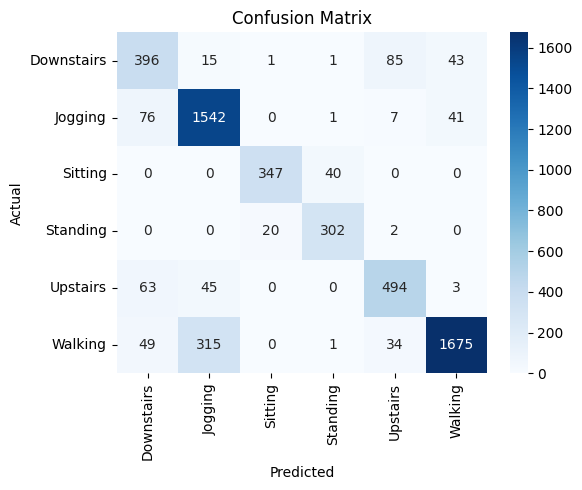

In [25]:
cm = confusion_matrix(y_test_int, y_pred_int)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()